In [1]:
#!pip install lazypredict

In [2]:
#pip install -U scikit-learn

In [1]:
import pandas as pd
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

In [2]:
df=pd.read_csv("../data/engineering_water_quality.csv")

In [3]:
df.head()

,Sample Site,Sample Date,Analyte,Final Result,Units,Stream Group,Year,Log Final Result,Month,Season,Stream Group Encoded,Season Encoded,Sample Site Encoded,Final Result Scaled,Log Final Result Scaled,Day,Weekday,Turbidity Rolling Avg
0,S4,1987-01-07,Temperature,1.11,C,Schoharie,1987,0.11,1,Winter,14,3,340,-0.04,-0.75,7,2,1.31
1,S6I,1987-01-07,Temperature,0.56,C,Schoharie,1987,-0.59,1,Winter,14,3,343,-0.04,-1.07,7,2,1.26
2,S8,1987-01-07,Temperature,2.22,C,Schoharie,1987,0.80,1,Winter,14,3,355,-0.03,-0.43,7,2,1.47
3,S4,1987-01-07,Scent Character,6.97,mg/L,Schoharie,1987,1.94,1,Winter,14,3,340,-0.03,0.11,7,2,1.31
4,S6I,1987-01-07,Scent Character,6.97,mg/L,Schoharie,1987,1.94,1,Winter,14,3,343,-0.03,0.11,7,2,1.26


In [4]:
df.shape

(2038120, 18)

In [5]:
df.isna().sum()

Sample Site                    0
Sample Date                    0
Analyte                        0
Final Result                   0
Units                          0
Stream Group                   0
Year                           0
Log Final Result           28895
Month                          0
Season                         0
Stream Group Encoded           0
Season Encoded                 0
Sample Site Encoded            0
Final Result Scaled            0
Log Final Result Scaled    28895
Day                            0
Weekday                        0
Turbidity Rolling Avg      51705
dtype: int64

In [6]:
#defining imputer with median strategy
imputer=SimpleImputer(strategy="median")
df[['Log Final Result', 'Log Final Result Scaled', 'Turbidity Rolling Avg']]=imputer.fit_transform(df[['Log Final Result', 'Log Final Result Scaled', 'Turbidity Rolling Avg']])

In [7]:
df.isna().sum()

Sample Site                0
Sample Date                0
Analyte                    0
Final Result               0
Units                      0
Stream Group               0
Year                       0
Log Final Result           0
Month                      0
Season                     0
Stream Group Encoded       0
Season Encoded             0
Sample Site Encoded        0
Final Result Scaled        0
Log Final Result Scaled    0
Day                        0
Weekday                    0
Turbidity Rolling Avg      0
dtype: int64

In [8]:
# Select only numeric columns for correlation analysis
numeric_df = df.select_dtypes(include=['number'])

# Compute correlation with 'Final Result'
correlation_with_target = numeric_df.corr()['Final Result'].sort_values(ascending=False)
print(correlation_with_target)

Final Result Scaled        1.00
Final Result               1.00
Log Final Result           0.10
Log Final Result Scaled    0.10
Weekday                    0.04
Year                       0.02
Day                        0.01
Month                      0.01
Turbidity Rolling Avg      0.00
Sample Site Encoded        0.00
Stream Group Encoded       0.00
Season Encoded            -0.01
Name: Final Result, dtype: float64


In [9]:
#defining the target variable
y=df['Final Result']

#dropping non-relevant columns from X
X=df.drop(columns=['Sample Site', 'Sample Date', 'Analyte','Final Result','Units','Stream Group', 'Log Final Result Scaled','Log Final Result','Final Result Scaled'])

#verifying selected features
print("Selected features for X:", X.columns.tolist())

Selected features for X: ['Year', 'Month', 'Season', 'Stream Group Encoded', 'Season Encoded', 'Sample Site Encoded', 'Day', 'Weekday', 'Turbidity Rolling Avg']


In [10]:
#converting categorical features into numeric if they are still in text format
if 'Season' in X.columns:
    X['Season']=X['Season'].astype('category').cat.codes

print(X.dtypes)

Year                       int64
Month                      int64
Season                      int8
Stream Group Encoded       int64
Season Encoded             int64
Sample Site Encoded        int64
Day                        int64
Weekday                    int64
Turbidity Rolling Avg    float64
dtype: object


In [13]:
#splitting the dataset
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

#standardizing features
#scaler=StandardScaler()
#X_train=scaler.fit_transform(X_train)
#X_test=scaler.transform(X_test)

# Standardize y
scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

In [15]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print("Random Forest RMSE:", mean_squared_error(y_test, y_pred_rf)** 0.5)
print("Random Forest R²:", r2_score(y_test, y_pred_rf))

Random Forest RMSE: 9539.800706086724
Random Forest R²: 0.00803974484880654


In [11]:
#dictionary to store model results
results={}
# Train models with scaled y
models = {'Linear Regression': LinearRegression(), 'Ridge Regression': Ridge(alpha=1.0), 'Lasso Regression': Lasso(alpha=0.1)}

# Dictionary to store results
results = {}

for name, model in models.items():
    model.fit(X_train, y_train_scaled)
    y_pred = model.predict(X_test)

    results[name] = {
        "RMSE": mean_squared_error(y_test_scaled, y_pred) ** 0.5,  # Corrected RMSE Calculation
        "R²": r2_score(y_test_scaled, y_pred)
    }

In [12]:
#displaying results
results_df=pd.DataFrame(results).T
results_df=results_df.sort_values(by="RMSE",ascending=True)
results_df

,RMSE,R²
Linear Regression,0.99,0.00
Ridge Regression,0.99,0.00
Lasso Regression,0.99,0.00


In [13]:
print(y_train.describe())
print(y_test.describe())

count   1630496.00
mean        217.59
std        9649.79
min         -16.39
25%           2.22
50%           6.97
75%          12.94
max     1470000.00
Name: Final Result, dtype: float64
count    407624.00
mean        218.46
std        9578.39
min          -2.22
25%           2.20
50%           6.97
75%          12.95
max     1470000.00
Name: Final Result, dtype: float64


In [14]:
print(pd.DataFrame(X_train).var())

Year                      102.91
Month                      11.21
Season                      1.26
Stream Group Encoded       23.71
Season Encoded              1.26
Sample Site Encoded     14578.54
Day                        73.32
Weekday                     1.74
Turbidity Rolling Avg     516.51
dtype: float64


In [15]:
print(df.corr()['Final Result'].sort_values(ascending=False))

ValueError: could not convert string to float: 'S4'

In [14]:
#run LazyRegressor
reg=LazyRegressor(verbose=0, ignore_warnings=True,custom_metric=None)
models,predictions=reg.fit(X_train[:5000],X_test[:5000],y_train[:5000],y_test[:5000])

100%|███████████████████████████████████████████| 42/42 [03:30<00:00,  5.00s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 9
[LightGBM] [Info] Start training from score 95.266114


In [15]:
#showing top 10 models sorted by RMSE
print(models.sort_values(by="RMSE").head(10))

                             Adjusted R-Squared  R-Squared    RMSE  Time Taken
Model                                                                         
BayesianRidge                             -0.00       0.00 1096.41        0.03
TweedieRegressor                          -0.00       0.00 1096.53        0.02
ElasticNet                                -0.00       0.00 1096.72        0.02
ElasticNetCV                              -0.00       0.00 1096.73        0.11
LassoCV                                   -0.00      -0.00 1096.74        0.13
LassoLarsCV                               -0.00      -0.00 1096.74        0.04
LarsCV                                    -0.00      -0.00 1096.74        0.04
DummyRegressor                            -0.00      -0.00 1096.74        0.01
LassoLarsIC                               -0.00      -0.00 1096.75        0.03
OrthogonalMatchingPursuitCV               -0.00      -0.00 1097.15        0.06


In [16]:
#saving mode comparison results to a file for review
#models.to_csv("lazy_regressor_results.csv", index=True)
#print("LazyRegressor results saved")

<function matplotlib.pyplot.show(close=None, block=None)>

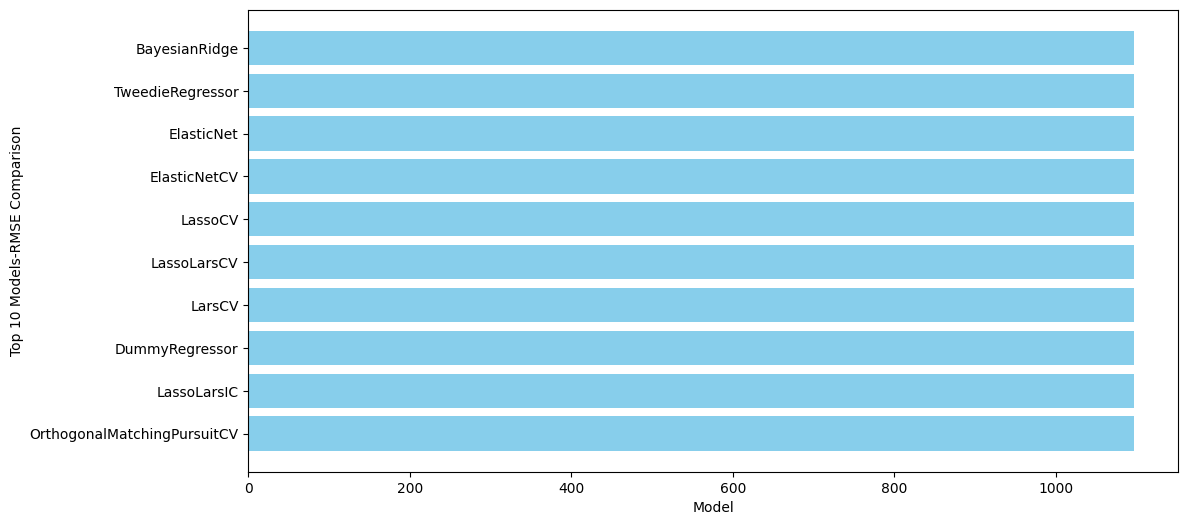

In [17]:
#sort models by RMSE
model_sorted=models.sort_values(by="RMSE")

#plotting RMSE for top models
plt.figure(figsize=(12,6))
plt.barh(model_sorted.index[:10], model_sorted["RMSE"][:10], color="skyblue")
plt.xlabel("Model")
plt.ylabel("Top 10 Models-RMSE Comparison")
plt.gca().invert_yaxis()
plt.show

In [18]:
#finding best model based on RMSE
best_model=models.sort_values(by="RMSE").head(1)
print("Best Model Selected:")
print(best_model)

Best Model Selected:
               Adjusted R-Squared  R-Squared    RMSE  Time Taken
Model                                                           
BayesianRidge               -0.00       0.00 1096.41        0.03
